# Record Disambiguation

### Algorithm
We will use confidence scores and spatial weights to determine the correct matches. This involves:

1. Generation of confidence score based on matches. Current formula used is: 
50% - Jaro-Winkler distance  
20% - No. of CD matches (conflicts)  
20% - No. of census matches  
5% - Absence of occupation in the census  
5% - Whether age is smaller than 12  
More documentation is found in `spatial-disambiguation.ipynb`.

2. Creation of spatial weights: A graph is created, with each node being a potential CD-census match and each edge being the link between the potential CD records of consecutive census records. A shortest path algorithm (Djikstra's) is run on the graph to get the nodes which comprise the shortest path. Matches involved in the shortest path are given a weight of +1. 

3. Matching algorithm: A bipartite graph is created from the matches, with each node being either a census or CD record and each edge indicating a potential match. The matching algorithm (maximum weighted matching) will (1) select sets of matches that give the highest number of matches (2) choose the match set that has the highest weight based on that. This match set will be the 'correct' matches for our disambiguation purposes. This step is needed because the lowest cost algorithm may select multiple CD records.

**This is further demonstrated with examples below**

In [1]:
import pandas as pd
import networkx as nx

In [10]:
# this is the df of matches with the correct confidence score (see spatial-disambiguation.ipynb)
df = pd.read_csv("../data/matches.csv")

In [11]:
df['CENSUS_ID'] = df['CENSUS_ID'].str[7:].astype(int)
df['CD_ID'] = df['CD_ID'].str[3:].astype(int)

## Function Definitions
UPDATE: check src/disambiguation.py for updated function definitions (some name changes)

In [4]:
# Create node ID for each match, to be using the shortest path algorithm 
# Also select relavant columns
# sub must be a df with each row as a potential match between a CD and census record. It must contain the columns CD_ID, CENSUS_ID, LONG, LAT, confidence_score and MATCH_ADDR
# returns the dataframe with new columns, 'anchor', 'node_ID' and 'letter'.
# anchor: whether row is an anchor (confidence score = 1)
# node_ID: unique node ID. each node is a match, so e.g. A0 and A1 refers to two potential CD matches for the same census record
# letter: grouping for identical census records 

def clean_matches(sub):
    sub_graph = sub.loc[:, ['CD_ID', 'CENSUS_ID', 'LONG', 'LAT', 'confidence_score', 'MATCH_ADDR']]
    sub_graph['anchor'] = sub_graph['confidence_score'].apply(lambda x: 1 if x == 1 else 0)
    sub_graph['node_ID'] = sub_graph.groupby('CENSUS_ID').cumcount()

    letter_id = sub_graph['CENSUS_ID'].unique().tolist()
    letters = [chr(x+65) for x in range(0, len(letter_id))]
    letter_id = pd.DataFrame({'CENSUS_ID': letter_id, 'letter': letters})

    sub_graph = sub_graph.merge(letter_id, how='left', on='CENSUS_ID', validate='many_to_one')

    sub_graph['node_ID'] = sub_graph.apply(lambda row: row.letter + str(row.node_ID), axis=1)
    
    return sub_graph

In [5]:
# Creates a graph from the sub_graph dataframe
# Each node being a potential CD-census match and 
# each edge being the link between the potential CD records of consecutive census records
# The weight of each edge = the manhattan distance between the two
# Returns the graph object

def shortest_path_graph(sub_graph):
    g = sub_graph
    g['key'] = 0
    g = g.merge(g, on='key')
    g['key'] = g.apply(lambda row: 1 if ord(row.letter_x) - ord(row.letter_y) == -1 else 0, axis = 1)
    g = g[g.key == 1]

    g['weight'] = g.apply(lambda row: ((row.LONG_y - row.LONG_x)**2 + (row.LAT_y - row.LONG_x)**2)**(1/2), axis=1)
    g_edges = [(row.node_ID_x, row.node_ID_y, row.weight) for index, row in g.iterrows()]
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(g_edges)
    
    return graph

In [6]:
# Runs dijkstra's algorithm on graph and returns the shortest path
def shortest_path_nodes(sub_graph, g):
    first_node = sub_graph.loc[0, 'node_ID']
    last_node = sub_graph.loc[len(sub_graph)-1, 'node_ID']
    path = nx.dijkstra_path(g, first_node, last_node, 'weight')
    
    return path

In [7]:
# Using the shortest path, compute weight for each record. Each record's weight = confidence + 1 if the match was involved in the shortest path and + 0 otherwise.
def apply_weight(sub_graph, path):
    sub_graph['weight'] = sub_graph.apply(lambda row: row.confidence_score + 1 if row.node_ID in path else row.confidence_score, axis = 1)
    return sub_graph

In [8]:
# Run  A bipartite graph is created from the matches, with each node being either a census or CD record and each edge indicating a potential match. 
# The matching algorithm (maximum weighted matching) will 
# (1) select sets of matches that give the highest number of matches 
# (2) choose the match set that has the highest weight based on that
# Returns a dictionary with 'graph' as the bipartite graph object and 'results' being the match results

def matches(sub_graph):
    b_edges = [(row.CD_ID, row.CENSUS_ID, row.weight) for index, row in sub_graph.iterrows()]
    b = nx.DiGraph()
    b.add_weighted_edges_from(b_edges)
    matches = nx.max_weight_matching(b, maxcardinality = True)
    
    return {'graph': b, 'results': matches}

## Demo

### Example 1

In [12]:
sub = df[(df.CENSUS_ID >= 1046) & (df.CENSUS_ID <= 1165)]

### Step 1: Preprocessing
Generate node ID for each match. Identical census records are given the same letter.

In [13]:
sub = clean_matches(sub)

### Step 2: find the shortest path

`shortest_path_graph()` will create a graph object like below. A-I represent consecutive census records, and the number represents the different CD records matched to a census record. E.g., G0 and G1 represent 2 different CD record matches for the same census record. By determining which node gives the overall smallest spatial distance, we can determine which matches are the most likely. E.g. in this case, because a path involving G0 and H0 would lead to the smallest distance among consecutive census records, we determine that G0 and H0 are the likeliest matches.

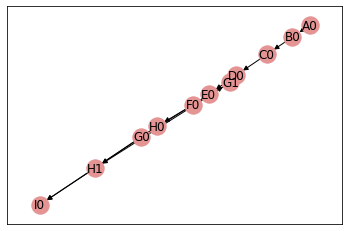

In [76]:
g = shortest_path_graph(sub)
nx.draw_networkx(g, with_labels=True, node_color = "#E59494")

These nodes will represent the combination of nodes giving the smallest path distance.

In [22]:
nodes = shortest_path_nodes(sub, g)
nodes

['A0', 'B0', 'C0', 'D0', 'E0', 'F0', 'G0', 'H0', 'I0']

### Step 3: Add weights based on spatial weight + confidence score
Matches that are part of the shortest path are given an additional score of 1. This adds a spatial dimension to the match score weighting.

In [23]:
weighted_df = apply_weight(sub, nodes)
weighted_df

,CD_ID,CENSUS_ID,LONG,LAT,confidence_score,MATCH_ADDR,anchor,node_ID,letter,key,weight
0,111096,1046,-74.010403,40.703759,1.00,"74 PEARL ST, New York, NY",1,A0,A,0,2.00
1,173365,1072,-74.013676,40.702483,0.90,"6 STATE ST, New York, NY",0,B0,B,0,1.90
2,8715,1080,-74.010523,40.702785,0.80,"40 FRONT ST, New York, NY",0,C0,C,0,1.80
3,8715,1081,-74.010523,40.702785,0.90,"40 FRONT ST, New York, NY",0,D0,D,0,1.90
4,82090,1119,-74.011323,40.704394,0.87,"34 S WILLIAM ST, New York, NY",0,E0,E,0,1.87
5,76251,1152,-74.010875,40.701938,0.99,"17 SOUTH ST, New York, NY",0,F0,F,0,1.99
6,160240,1158,-74.010980,40.701913,0.80,"16 SOUTH ST, New York, NY",0,G0,G,0,1.80
7,160237,1158,-74.011102,40.701948,0.80,"129 BROAD ST, New York, NY",0,G1,G,0,0.80
8,160240,1162,-74.010980,40.701913,0.80,"16 SOUTH ST, New York, NY",0,H0,H,0,1.80
9,160237,1162,-74.011102,40.701948,0.80,"129 BROAD ST, New York, NY",0,H1,H,0,0.80


### Step 4: Find the matches that maximise confidence weight
This algorithm selects the set of matches that maximises number of matches and has the highest sum of weights.

A visualization of the bipartite graph (left = CD records, right = census records)

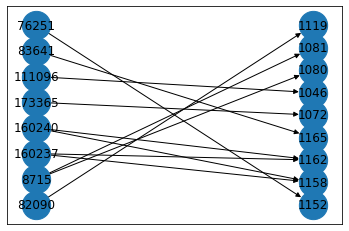

In [31]:
b = matches(weighted_df)['graph']
nx.draw_networkx(b, pos = nx.drawing.layout.bipartite_layout(b, weighted_df['CD_ID'].tolist()), node_size = 800)

In [26]:
matches(weighted_df)['results']

{(1072, 173365),
 (1081, 8715),
 (1152, 76251),
 (1162, 160237),
 (82090, 1119),
 (83641, 1165),
 (111096, 1046),
 (160240, 1158)}